In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
%matplotlib inline

In [3]:
# create directory variables for easy access to data
main_dir = '../input/chest-xray-pneumonia/chest_xray/'
train_data_dir = main_dir + 'train/'
validation_data_dir = main_dir + 'validation/'
test_data_dir = main_dir + 'test/'
train_n = train_data_dir + 'NORMAL/'
train_p = train_data_dir + 'PNEUMONIA/'

In [4]:
# Split the images into normal and pneumonia
normal_images = [fn for fn in os.listdir(train_n) if fn.endswith('.jpeg')]
pneumonia_images = [fn for fn in os.listdir(train_p) if fn.endswith('.jpeg')]

In [5]:
# select three images randomly from both categories
random_normal = np.random.choice(normal_images, 3, replace=False)
random_pneu = np.random.choice(pneumonia_images, 3, replace=False)
print(random_normal)
print(random_pneu)

['IM-0168-0001.jpeg' 'NORMAL2-IM-1292-0001.jpeg' 'IM-0618-0001-0002.jpeg']
['person524_virus_1045.jpeg' 'person26_bacteria_122.jpeg'
 'person1352_bacteria_3443.jpeg']


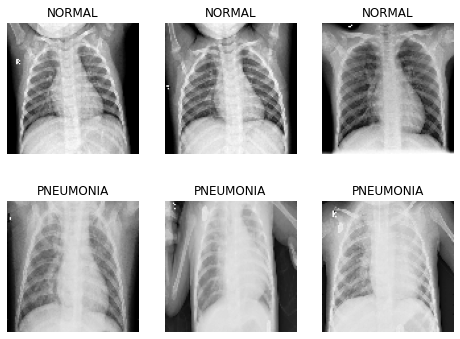

In [6]:
# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = f'{train_n}/{random_normal[i]}'
        label = 'NORMAL'
    else:
        fp = f'{train_p}/{random_pneu[i-3]}'
        label = 'PNEUMONIA'
    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (100,100), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

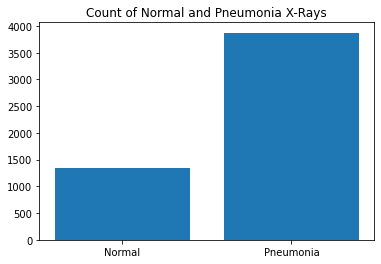

Normal: 1341
Pneumonia: 3875


In [7]:
# view the number of Normal vs Pneumonia x-ray images
X = [len(normal_images), len(pneumonia_images)]
plt.bar(['Normal', 'Pneumonia'],X)
plt.title('Count of Normal and Pneumonia X-Rays')
plt.show()
print(f'Normal: {len(normal_images)}')
print(f'Pneumonia: {len(pneumonia_images)}')

### Pneumonia Distribution
The data is imbalanced between Normal and Pneumonia. A good technique that can be used to get closer to a balanced dataset is during that during the image augmentation process, resample the Normal images at a higher percentage than the Pneumonia group.

## Convert the images into Numpy pixel arrays

In [8]:
# create a function for image conversion to numpy array
def image2numpy(path, list_of_filenames, size=(64, 64)):
    # iterate through each file
    for filename in list_of_filenames:
        filepath = path + filename
        current_image = image.load_img(filepath, target_size=size, color_mode='grayscale')
        
        # convert image to a matrix n x m size 
        # n is number of observations and m is the number of samples
        img_ts = image.img_to_array(current_image)
    
        # turn into vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate images to the full list
            full_matrix = np.concatenate((full_matrix, img_ts))
        except:
            # on the first round full_matrix needs to be assigned
            full_matrix = img_ts
        
    return full_matrix


In [9]:
# create pixel matrices for the normal and the pneumonia datasets
normal_images_matrix = image2numpy(f'{train_data_dir}/NORMAL/', normal_images)
pneumonia_images_matrix = image2numpy(f'{train_data_dir}/PNEUMONIA/', pneumonia_images)

#### There is now a normal matrix and a pneumonia matrix with all the X-ray images as a single array per X-ray

In [10]:
# confirm number of x-rays and number of pixels
print('Normal Images Count:', len(normal_images))
print('Normal Images Pixel Count:', len(normal_images_matrix[0]))
print('Pneumonia Images Count:', len(pneumonia_images))
print('Pneumonia Images Pixel Count:', len(pneumonia_images_matrix[0]))


Normal Images Count: 1341
Normal Images Pixel Count: 4096
Pneumonia Images Count: 3875
Pneumonia Images Pixel Count: 4096


#### This is what is expected for the output

## View the Average Image for Each Class

In [11]:
# create a function to get the mean of each pixel
def find_mean_image(full_matrix, class_name, size = (64, 64)):
    # caculate the average
    mean_image = np.mean(full_matrix, axis = 0)
    # reshape vector into a 64x64 matrix
    mean_image = mean_image.reshape(size)
    # display the image
    plt.imshow(mean_image, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {class_name}')
    plt.axis('off')
    plt.show()
    return mean_image

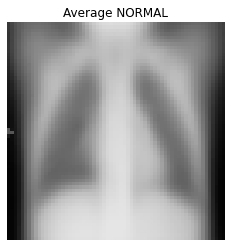

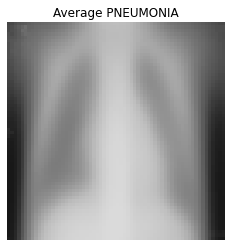

In [12]:
norm_mean = find_mean_image(normal_images_matrix, 'NORMAL')
pneumonia_mean = find_mean_image(pneumonia_images_matrix, 'PNEUMONIA')

## Analysis of Average Class X-ray:

The x-ray image for the pneumonia class has less clarity of the lungs. This leads me to beleive that even slight greying of the lungs area could be an indication of pneumonia. This would be difficult for a human to read, but by using a threshold for the amount of light pixels in the lung area, a machine could identify that quite easily.

## Contrast Between Average Images

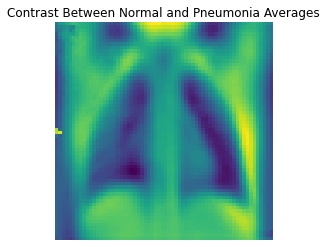

In [13]:
# calculate the difference between normal and pneumonia
contrast_mean = norm_mean - pneumonia_mean

# display the contrast
plt.imshow(contrast_mean)
plt.title('Contrast Between Normal and Pneumonia Averages')
plt.axis('off')
plt.show()

## Standard Deviation Between Normal and Pneumonia Images

In [14]:
# create a function to get the standard deviation of each pixel
def find_std_image(full_matrix, class_name, size = (64, 64)):
    # caculate the standard deviation
    std_image = np.std(full_matrix, axis = 0)*2 #double values for better visability
    # reshape vector into a 64x64 matrix
    std_image = std_image.reshape(size)
    # display the image
    plt.imshow(std_image, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {class_name}')
    plt.axis('off')
    plt.show()
    return std_image

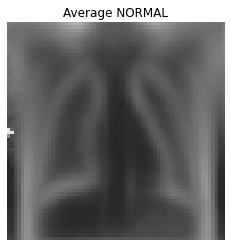

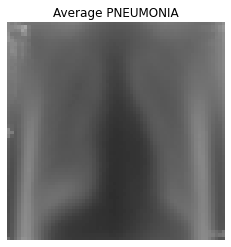

In [15]:
# view the standard deviation of each class
normal_std = find_std_image(normal_images_matrix, 'NORMAL')
pneumonia_std = find_std_image(pneumonia_images_matrix, 'PNEUMONIA')

## Analysis of Standard Deviation:

This clearly shows that pneumonia x-ray images have more variability in the lung region. So looking for a certain percentage of lighter pixels might be a good algorithmic indicator.

## Eigenimages

Use Principal Compenant Analysis (PCA) to plot the eigenvectors into an image.


In [16]:
from sklearn.decomposition import PCA
from math import ceil

In [17]:
def eigenimages(full_matrix, class_name, n_comp=0.7, size=(64,64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components=n_comp, whiten=True)
    pca.fit(full_matrix)
    print('Number of PC: ', pca.n_components_)
    return pca

def plot_pca(pca, size=(64,64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8,8))
    r = int(np.sqrt(n))
    c = ceil(n / r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i+1, xticks=[], yticks=[])
        ax.imshow(pca.components_[i].reshape(size), cmap='Greys_r')
        plt.axis('off')
        plt.show()
        
    

In [18]:
# calculate the principal components of the normal x-rays
normal_eigenimages = eigenimages(normal_images_matrix, 'NORMAL')


Number of PC:  28


## View the Normal X-Ray Eigenimages

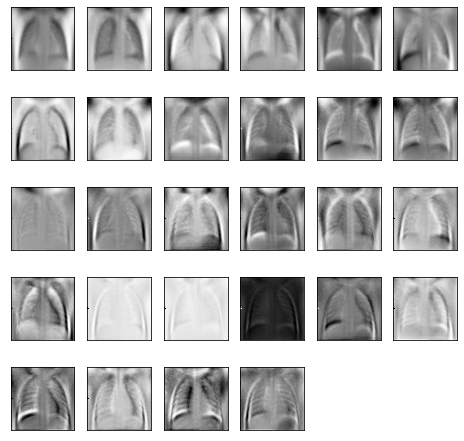

In [19]:
n = normal_eigenimages.n_components_
row = int(np.sqrt(n))
col = ceil(n / row)
size = (64,64)

fig = plt.figure(figsize=(8,8))

for i in range(n):
    ax = fig.add_subplot(row, col, i+1, xticks=[], yticks=[])
    ax.imshow(normal_eigenimages.components_[i].reshape(size), cmap='Greys_r')
    
plt.show()

## View the Pneumonia Eigenimages

In [20]:
# calculate the principal components of the pneumonia x-rays
pneumonia_eigenimages = eigenimages(pneumonia_images_matrix, 'PNEUMONIA')

Number of PC:  14


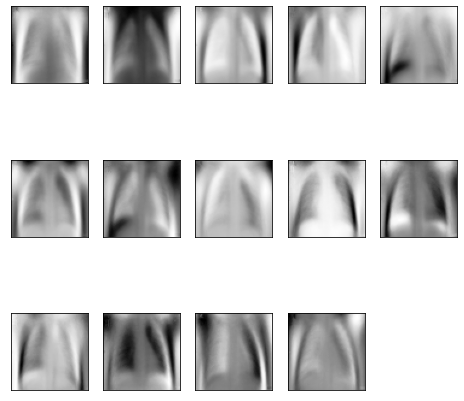

In [21]:
n = pneumonia_eigenimages.n_components_
row = int(np.sqrt(n))
col = ceil(n / row)
size = (64,64)

fig = plt.figure(figsize=(8,8))

for i in range(n):
    ax = fig.add_subplot(row, col, i+1, xticks=[], yticks=[])
    ax.imshow(pneumonia_eigenimages.components_[i].reshape(size), cmap='Greys_r')
    
plt.show()

## Analysis of the Eigenimages:

The normal X-rays have much more distinct edges to the principal components than do the pneumonia images. The lungs and rib cage are much more clearly defined in the normal images than in the pneumonia images.